In [1]:
%load_ext zipline
%load_ext watermark
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd
import numpy as np
from collections import OrderedDict
import pytz

# необходимые функции zipline
from zipline.api import (order, record, symbol, set_benchmark, order_target_percent, get_open_orders, order_target, 
                        schedule_function, date_rules, time_rules, order_percent, symbols)

# комиссии
from zipline.finance import commission

# выбор календаря по которому происходит торговля
from trading_calendars.always_open import AlwaysOpenCalendar

import zipline

# графика
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

# работа с временем
from datetime import datetime, date

# aинансовые данные
from yahoofinancials import YahooFinancials

# ignore warnings
import warnings

# отчёт
import pyfolio as pf

# import helper functions 
import qf_helper_functions as qf

import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import pylab

from tqdm import tqdm

In [3]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [16, 4]
plt.rcParams['figure.dpi'] = 200
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close', 'adjclose', 'volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date), color='green');

# BlackRock

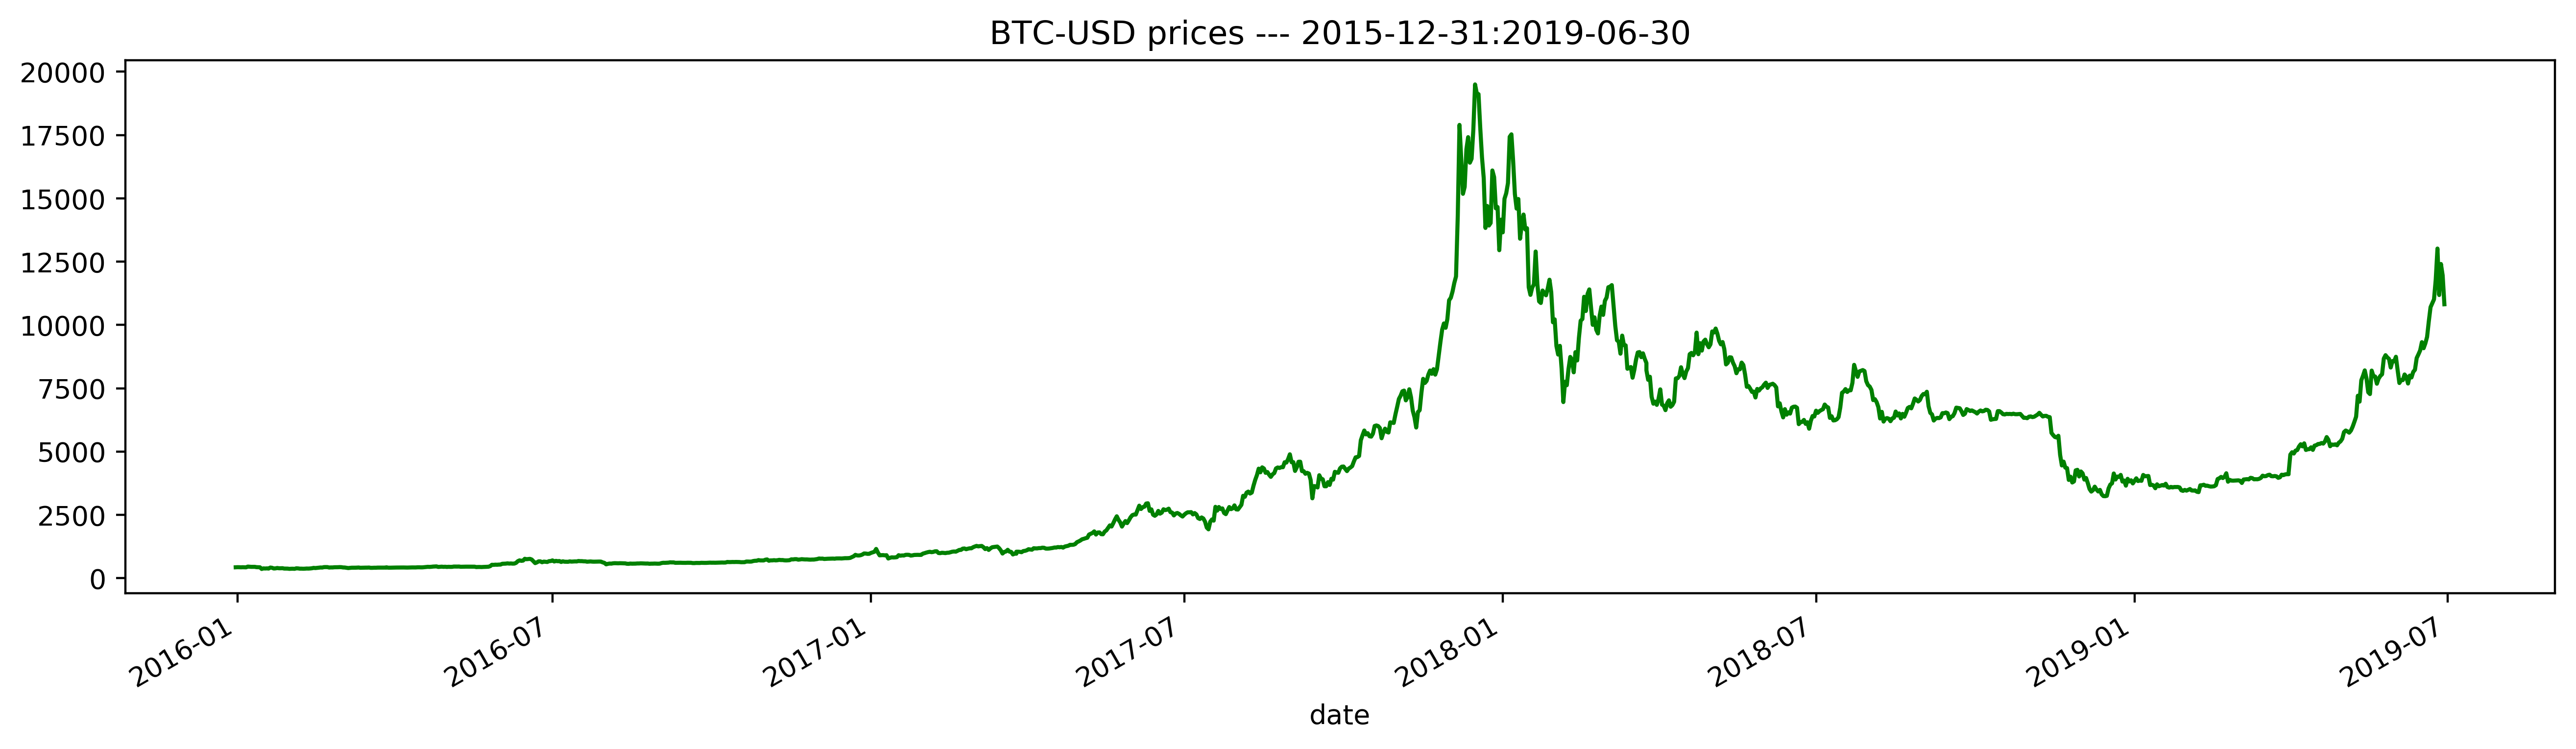

In [5]:
download_csv_data(ticker='BTC-USD', 
                  start_date='2015-12-31', 
                  end_date='2019-06-30', 
                  freq='daily', 
                  path='data/BTC.csv')

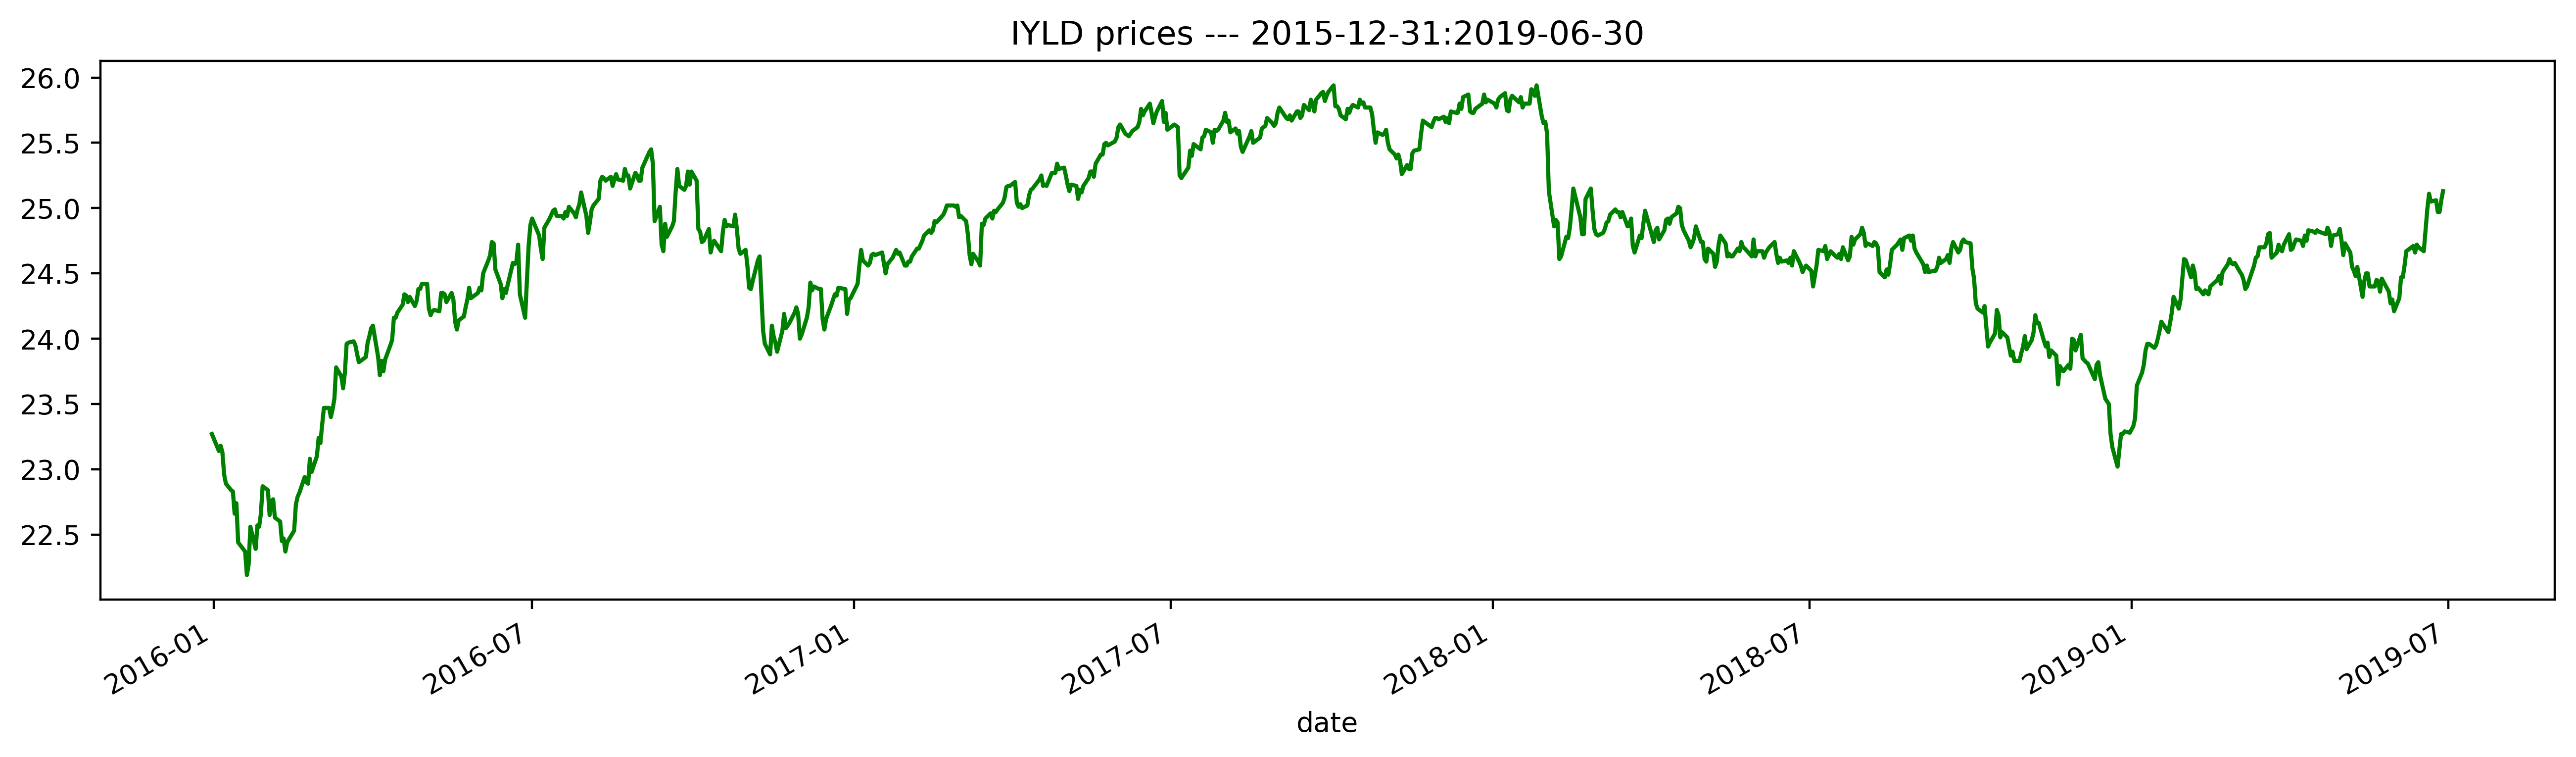

In [6]:
download_csv_data(ticker='IYLD', 
                  start_date='2015-12-31', 
                  end_date='2019-06-30', 
                  freq='daily', 
                  path='data/IYLD.csv')

# Симуляция с 5% BTC

In [7]:
# Список финансовых инструментов в портфеле
TIKERS = ['IYLD', 'BTC']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'close', 'adjclose']

In [8]:
data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    print(data[tiker].head())

             open      close   adjclose
date                                   
2015-12-31  23.35  23.270000  19.242931
2016-01-01  23.35  23.270000  19.242931
2016-01-02  23.35  23.270000  19.242931
2016-01-03  23.35  23.270000  19.242931
2016-01-04  23.27  23.139999  19.135437
                  open       close    adjclose
date                                          
2015-12-31  425.875000  430.566986  430.566986
2016-01-01  430.721008  434.334015  434.334015
2016-01-02  434.622009  433.437988  433.437988
2016-01-03  433.578003  430.010986  430.010986
2016-01-04  430.061005  433.091003  433.091003


In [9]:
for tiker in TIKERS:
    data[tiker]['close'] = data[tiker]['adjclose']
    data[tiker]['open'] = data[tiker]['adjclose']
    del data[tiker]['adjclose']
    print(data[tiker].tail())
COLUMNS = ['open', 'close']

                 open      close
date                            
2019-06-24  24.437832  24.437832
2019-06-25  24.350065  24.350065
2019-06-26  24.350065  24.350065
2019-06-27  24.437832  24.437832
2019-06-28  24.506094  24.506094
                    open         close
date                                  
2019-06-25  13016.231445  13016.231445
2019-06-26  11182.806641  11182.806641
2019-06-27  12407.332031  12407.332031
2019-06-28  11959.371094  11959.371094
2019-06-29  10817.155273  10817.155273


In [10]:
panel = pd.Panel(data)
panel.minor_axis = COLUMNS
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 2 (items) x 1277 (major_axis) x 2 (minor_axis)
Items axis: IYLD to BTC
Major_axis axis: 2015-12-31 00:00:00+00:00 to 2019-06-29 00:00:00+00:00
Minor_axis axis: open to close


In [11]:
WEIGHTS = [0.95, 0.05]
COMMISSION = 0.00125
DELTA = 0.025

In [12]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    
    set_benchmark(symbol('IYLD'))
    
    context.tikers = TIKERS
    context.assets = [context.symbol(symbol) for symbol in context.tikers]
    
    context.weights = WEIGHTS
    context.n_assets = len(context.assets)
    
    context.window = 1
    
    context.rebalance_count = 0
    
    context.time = 0

In [13]:
def handle_data(context, data):
    
    if context.time == 0:
        
        # extract prices
        prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])
            
        context.time += 1
    
    else:
        for i, asset in enumerate(context.assets):
            if abs(context.portfolio.current_portfolio_weights.get(key = asset) - context.weights[i]) > DELTA:
                order_target_percent(asset, context.weights[i])
                
                context.rebalance_count += 1
                
        context.time += 1
        

In [14]:
perf = zipline.run_algorithm(start=datetime(2015, 12, 31, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2019, 6, 30, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              capital_base=10000000,
                              handle_data=handle_data,
                              data=panel)

In [15]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

In [16]:
qf.get_performance_summary(returns)

annual_volatility     0.067028
annualized_returns    0.151008
cumulative_returns    0.634142
max_drawdown         -0.102939
sharpe_ratio          2.132258
sortino_ratio         3.265075
dtype: float64

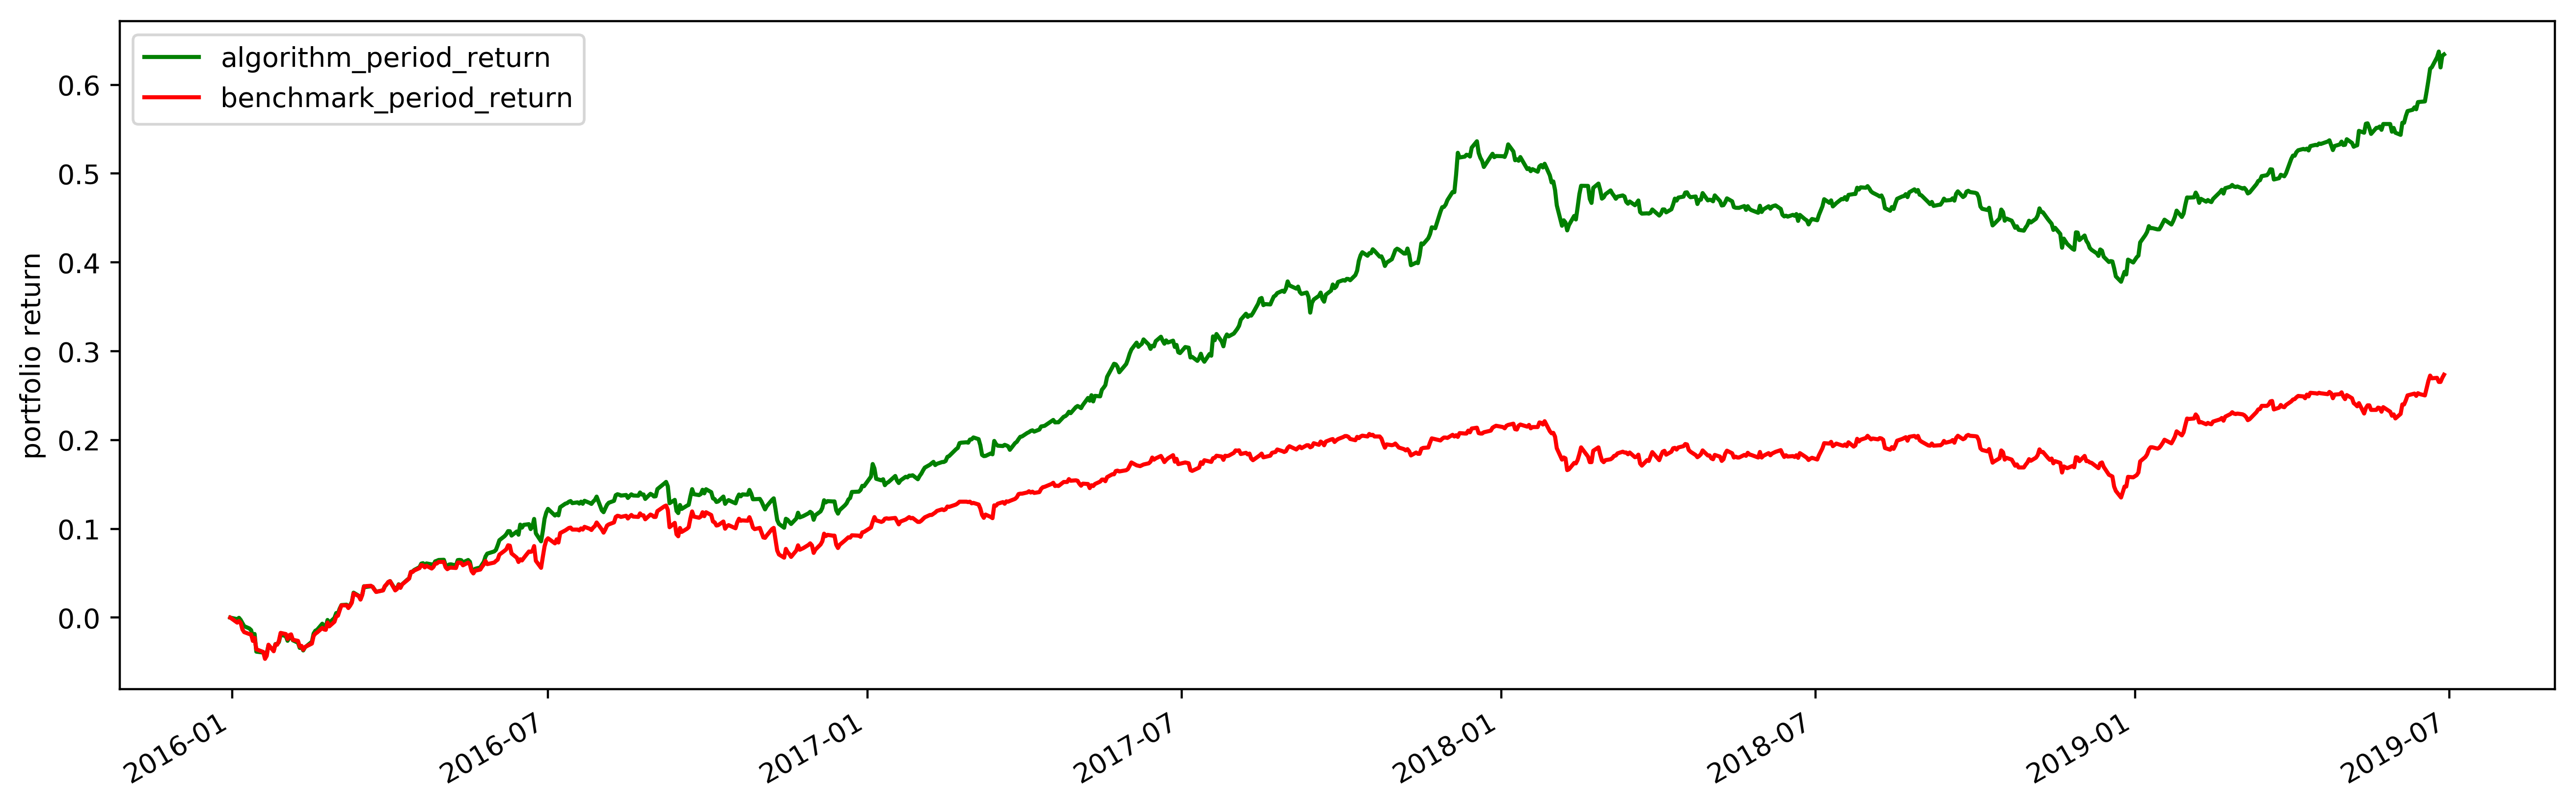

Final portfolio return: 63.41%
Final benchmark return: 27.35%


In [17]:
fig, ax = plt.subplots(figsize=[16, 5])

# portfolio value
perf.algorithm_period_return.plot(color='g')
perf.benchmark_period_return.plot(color='r')

ax.set_ylabel('portfolio return')

plt.legend()
plt.show()

print('Final portfolio return: {}%'.format(np.round(perf.algorithm_period_return[-1] * 100, 2)))
print('Final benchmark return: {}%'.format(np.round(perf.benchmark_period_return[-1] * 100, 2)))

In [18]:
(perf.portfolio_value/100000).tail()

2019-06-24 00:00:00+00:00    163.095235
2019-06-25 00:00:00+00:00    163.735760
2019-06-26 00:00:00+00:00    161.950686
2019-06-27 00:00:00+00:00    163.270168
2019-06-28 00:00:00+00:00    163.414193
Name: portfolio_value, dtype: float64

In [19]:
bitcoin5 = perf.algorithm_period_return

In [20]:
bitcoinPortfolio5 = 1000 * (1 + bitcoin5)

bitcoinPortfolio5 = bitcoinPortfolio5.rename('BTC 5% Target') 

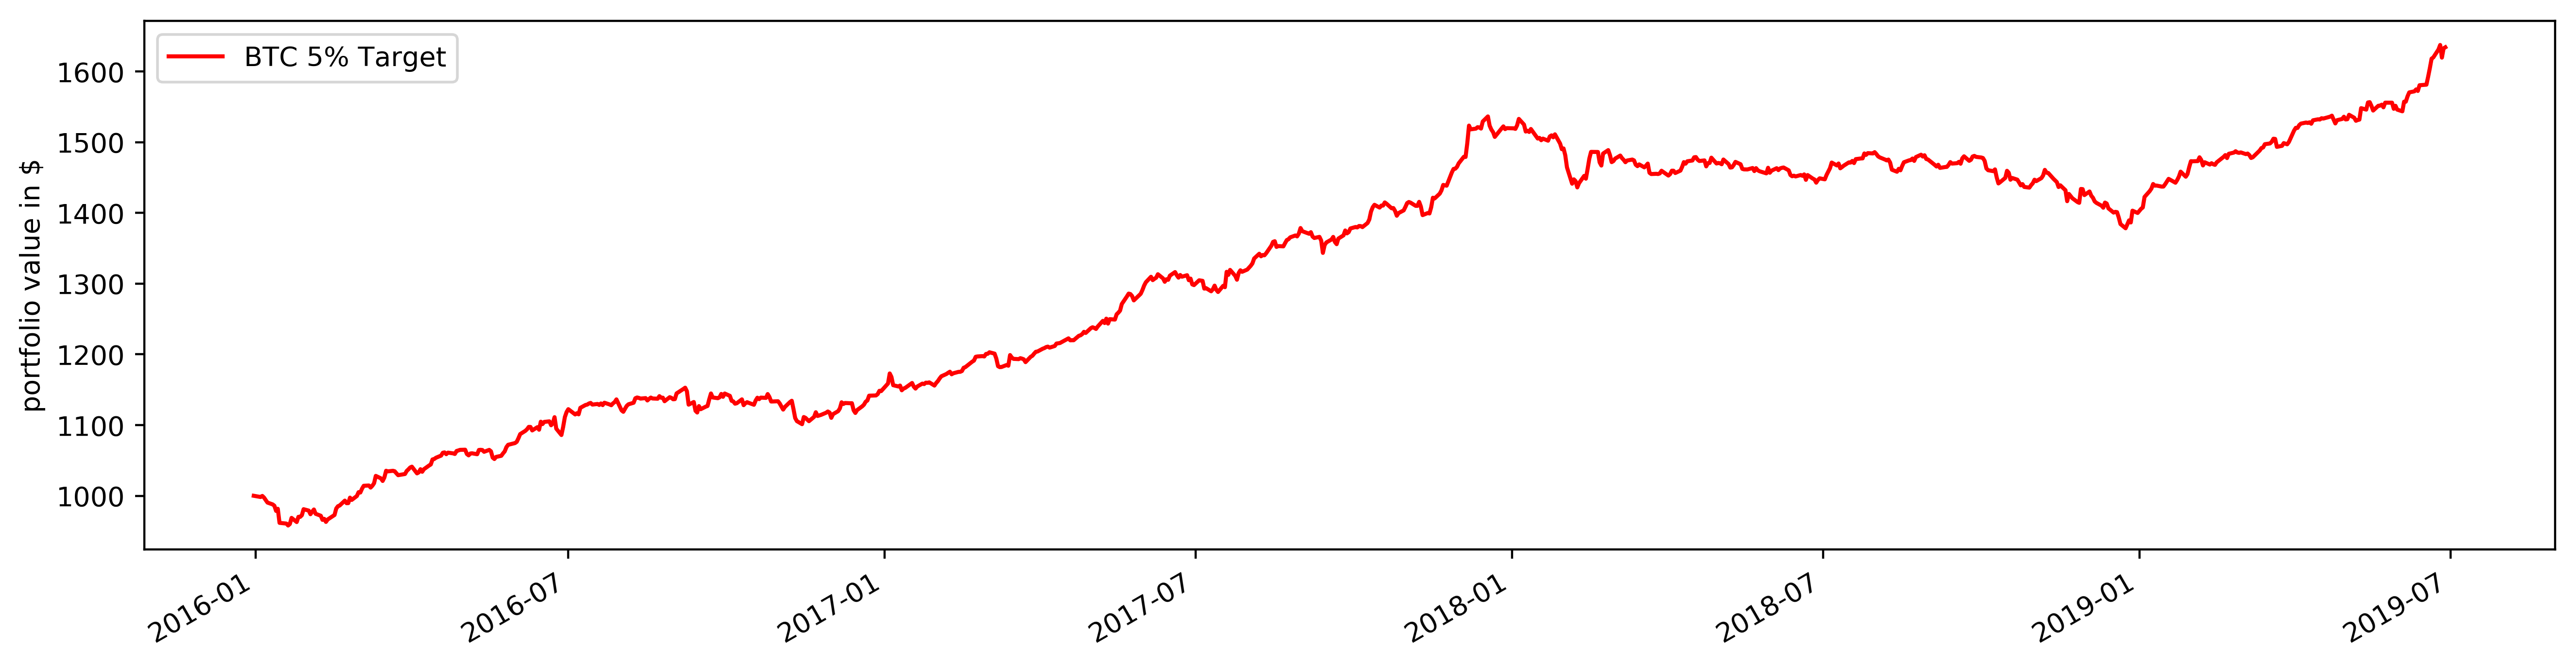

In [21]:
fig, ax = plt.subplots(figsize=[16, 4])

# portfolio value
bitcoinPortfolio5.plot(color='r')
#portfolio1.plot(color='gold')
#vanguard.plot(color='gray')

ax.set_ylabel('portfolio value in $')

plt.legend()
plt.show()

In [22]:
#Поправляем индексацию

new_index = pd.Series(pd.to_datetime(positions.index).date).map(lambda x: x.strftime('%Y-%m-%d'))
weights_df = pd.DataFrame.from_records(positions, index=new_index)
weights_df.head()

Equity(0 [IYLD])  Equity(1 [BTC])          cash
2016-01-04      9.446916e+06    502818.654968  32846.597936
2016-01-05      9.463245e+06    501505.550079  32846.597936
2016-01-06      9.442835e+06    498190.917755  32846.597936
2016-01-07      9.373430e+06    531793.732819  32846.597936
2016-01-08      9.344853e+06    526200.042755  32846.597936

In [23]:
# Поправляем названия столбцов

weights_df.columns = ['IYLD', 'BTC', 'Cash']

In [25]:
# Нормирование весов в файле

norm_weights_df = weights_df.copy()

norm_weights_df['BTC'] = weights_df['BTC']/(weights_df['BTC'] + weights_df['IYLD'] + weights_df['Cash'])    
norm_weights_df['IYLD'] = weights_df['IYLD']/(weights_df['IYLD'] + weights_df['BTC'] + weights_df['Cash'])
norm_weights_df['Cash'] = weights_df['Cash']/(weights_df['IYLD'] + weights_df['BTC'] + weights_df['Cash'])

In [26]:
# convert date objects from pandas format to python datetime
norm_weights_df.index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in norm_weights_df.index]

In [27]:
norm_weights_df.tail()

IYLD       BTC      Cash
2019-06-24  0.935614  0.070126 -0.005740
2019-06-25  0.928607  0.077110 -0.005718
2019-06-26  0.938843  0.043502  0.017656
2019-06-27  0.934612  0.047875  0.017513
2019-06-28  0.936396  0.046106  0.017497

ValueError: When stacked is True, each column must be either all positive or negative.Cash contains both positive and negative values

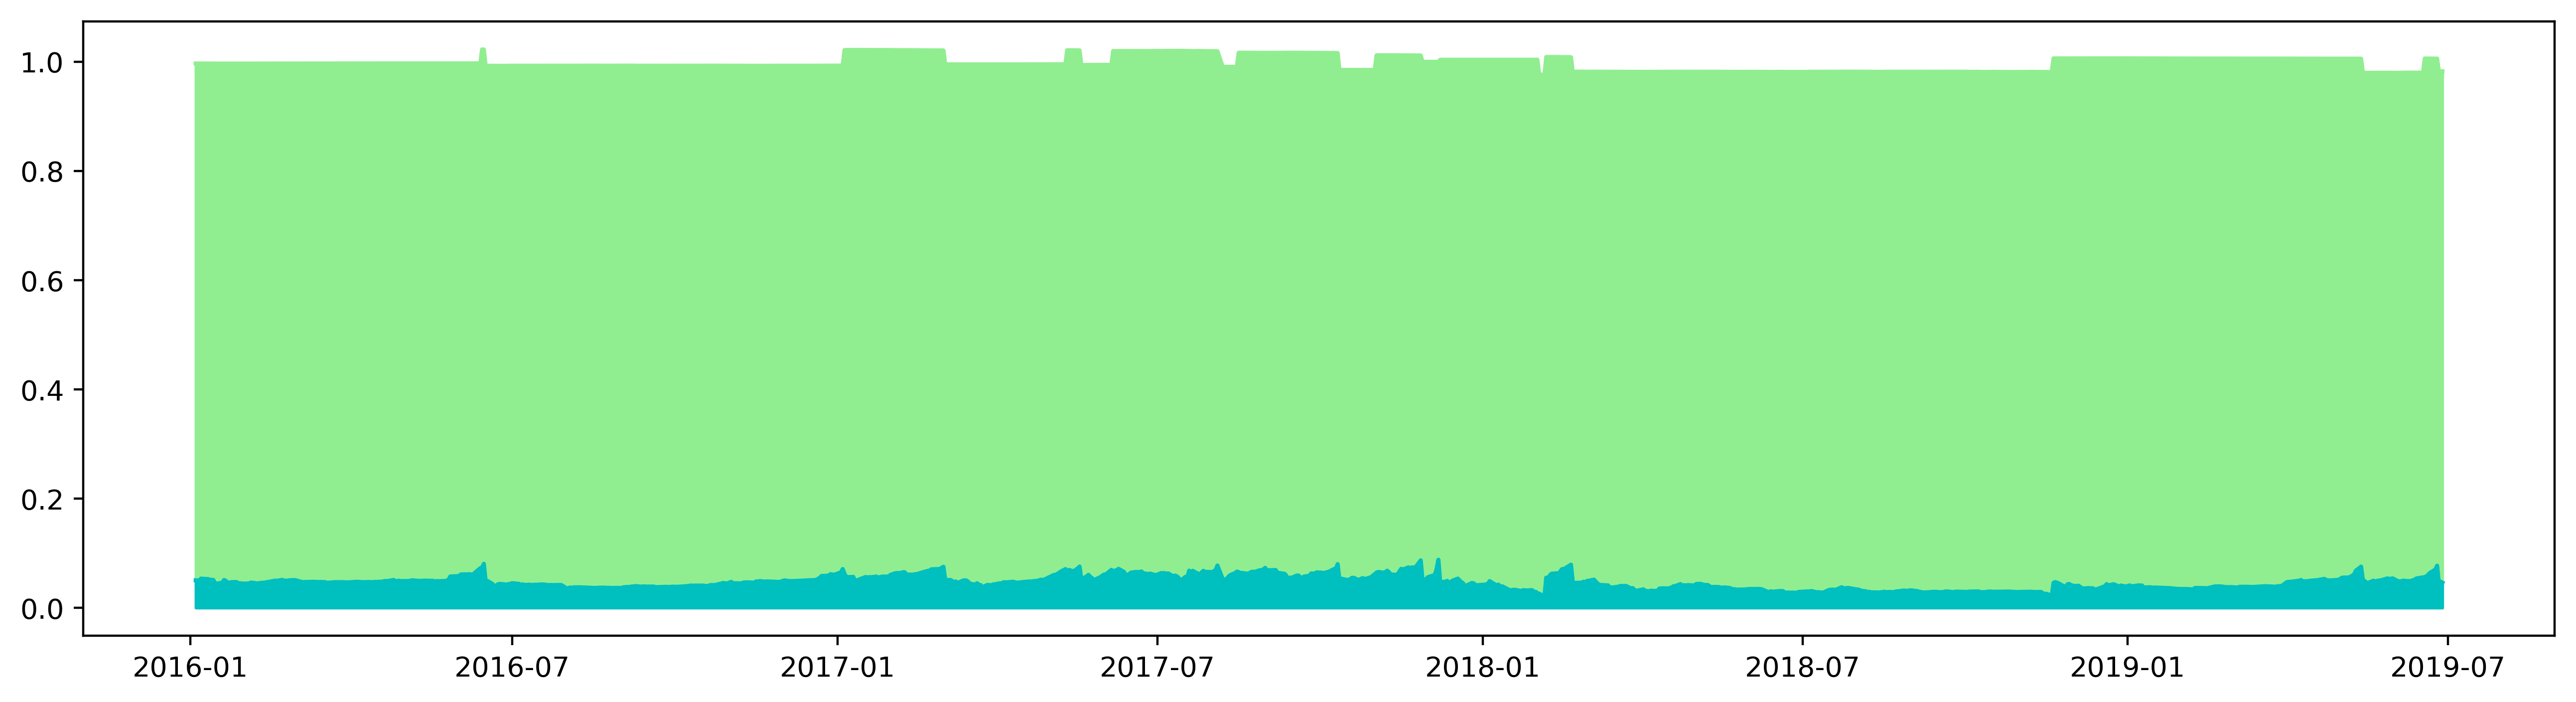

In [28]:
norm_weights_df = norm_weights_df[['BTC', 'IYLD', 'Cash']]
# plot the results
col = ['c', 'lightgreen', 'seagreen']
ax = norm_weights_df.plot(kind='area', stacked=True, color = col) # stacked=True показывает веса в одном столбце

# set monthly locator

##### Градуировка https://matplotlib.org/3.1.0/gallery/ticks_and_spines/tick-locators.html
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()

ax.tick_params(axis = 'both', direction = 'out')
ax.set(title = 'Paradigm strategy', ylabel='Allocation')
ax.legend(bbox_to_anchor=(1,1))
plt.show()

# Симуляция с 1% Bitcoin

In [29]:
# Список финансовых инструментов в портфеле
TIKERS = ['IYLD', 'BTC']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'close', 'adjclose']

In [30]:
data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    print(data[tiker].head())

             open      close   adjclose
date                                   
2015-12-31  23.35  23.270000  19.242931
2016-01-01  23.35  23.270000  19.242931
2016-01-02  23.35  23.270000  19.242931
2016-01-03  23.35  23.270000  19.242931
2016-01-04  23.27  23.139999  19.135437
                  open       close    adjclose
date                                          
2015-12-31  425.875000  430.566986  430.566986
2016-01-01  430.721008  434.334015  434.334015
2016-01-02  434.622009  433.437988  433.437988
2016-01-03  433.578003  430.010986  430.010986
2016-01-04  430.061005  433.091003  433.091003


In [31]:
for tiker in TIKERS:
    data[tiker]['close'] = data[tiker]['adjclose']
    data[tiker]['open'] = data[tiker]['adjclose']
    del data[tiker]['adjclose']
    print(data[tiker].tail())
COLUMNS = ['open', 'close']

                 open      close
date                            
2019-06-24  24.437832  24.437832
2019-06-25  24.350065  24.350065
2019-06-26  24.350065  24.350065
2019-06-27  24.437832  24.437832
2019-06-28  24.506094  24.506094
                    open         close
date                                  
2019-06-25  13016.231445  13016.231445
2019-06-26  11182.806641  11182.806641
2019-06-27  12407.332031  12407.332031
2019-06-28  11959.371094  11959.371094
2019-06-29  10817.155273  10817.155273


In [32]:
panel = pd.Panel(data)
panel.minor_axis = COLUMNS
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 2 (items) x 1277 (major_axis) x 2 (minor_axis)
Items axis: IYLD to BTC
Major_axis axis: 2015-12-31 00:00:00+00:00 to 2019-06-29 00:00:00+00:00
Minor_axis axis: open to close


In [33]:
WEIGHTS = [0.98, 0.01]
COMMISSION = 0.00125
DELTA = 0.025

In [34]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    
    set_benchmark(symbol('IYLD'))
    
    context.tikers = TIKERS
    context.assets = [context.symbol(symbol) for symbol in context.tikers]
    
    context.weights = WEIGHTS
    context.n_assets = len(context.assets)
    
    context.window = 1
    
    context.rebalance_count = 0
    
    context.time = 0

In [35]:
def handle_data(context, data):
    
    if context.time == 0:
        
        # extract prices
        prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])
            
        context.time += 1
    
    else:
        for i, asset in enumerate(context.assets):
            if abs(context.portfolio.current_portfolio_weights.get(key = asset) - context.weights[i]) > DELTA:
                order_target_percent(asset, context.weights[i])
                
                context.rebalance_count += 1
                
        context.time += 1

In [36]:
perf = zipline.run_algorithm(start=datetime(2015, 12, 31, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2019, 6, 30, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              capital_base=10000000,
                              handle_data=handle_data,
                              data=panel)

In [37]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

In [38]:
qf.get_performance_summary(returns)

annual_volatility     0.057271
annualized_returns    0.090621
cumulative_returns    0.353815
max_drawdown         -0.084138
sharpe_ratio          1.543569
sortino_ratio         2.231339
dtype: float64

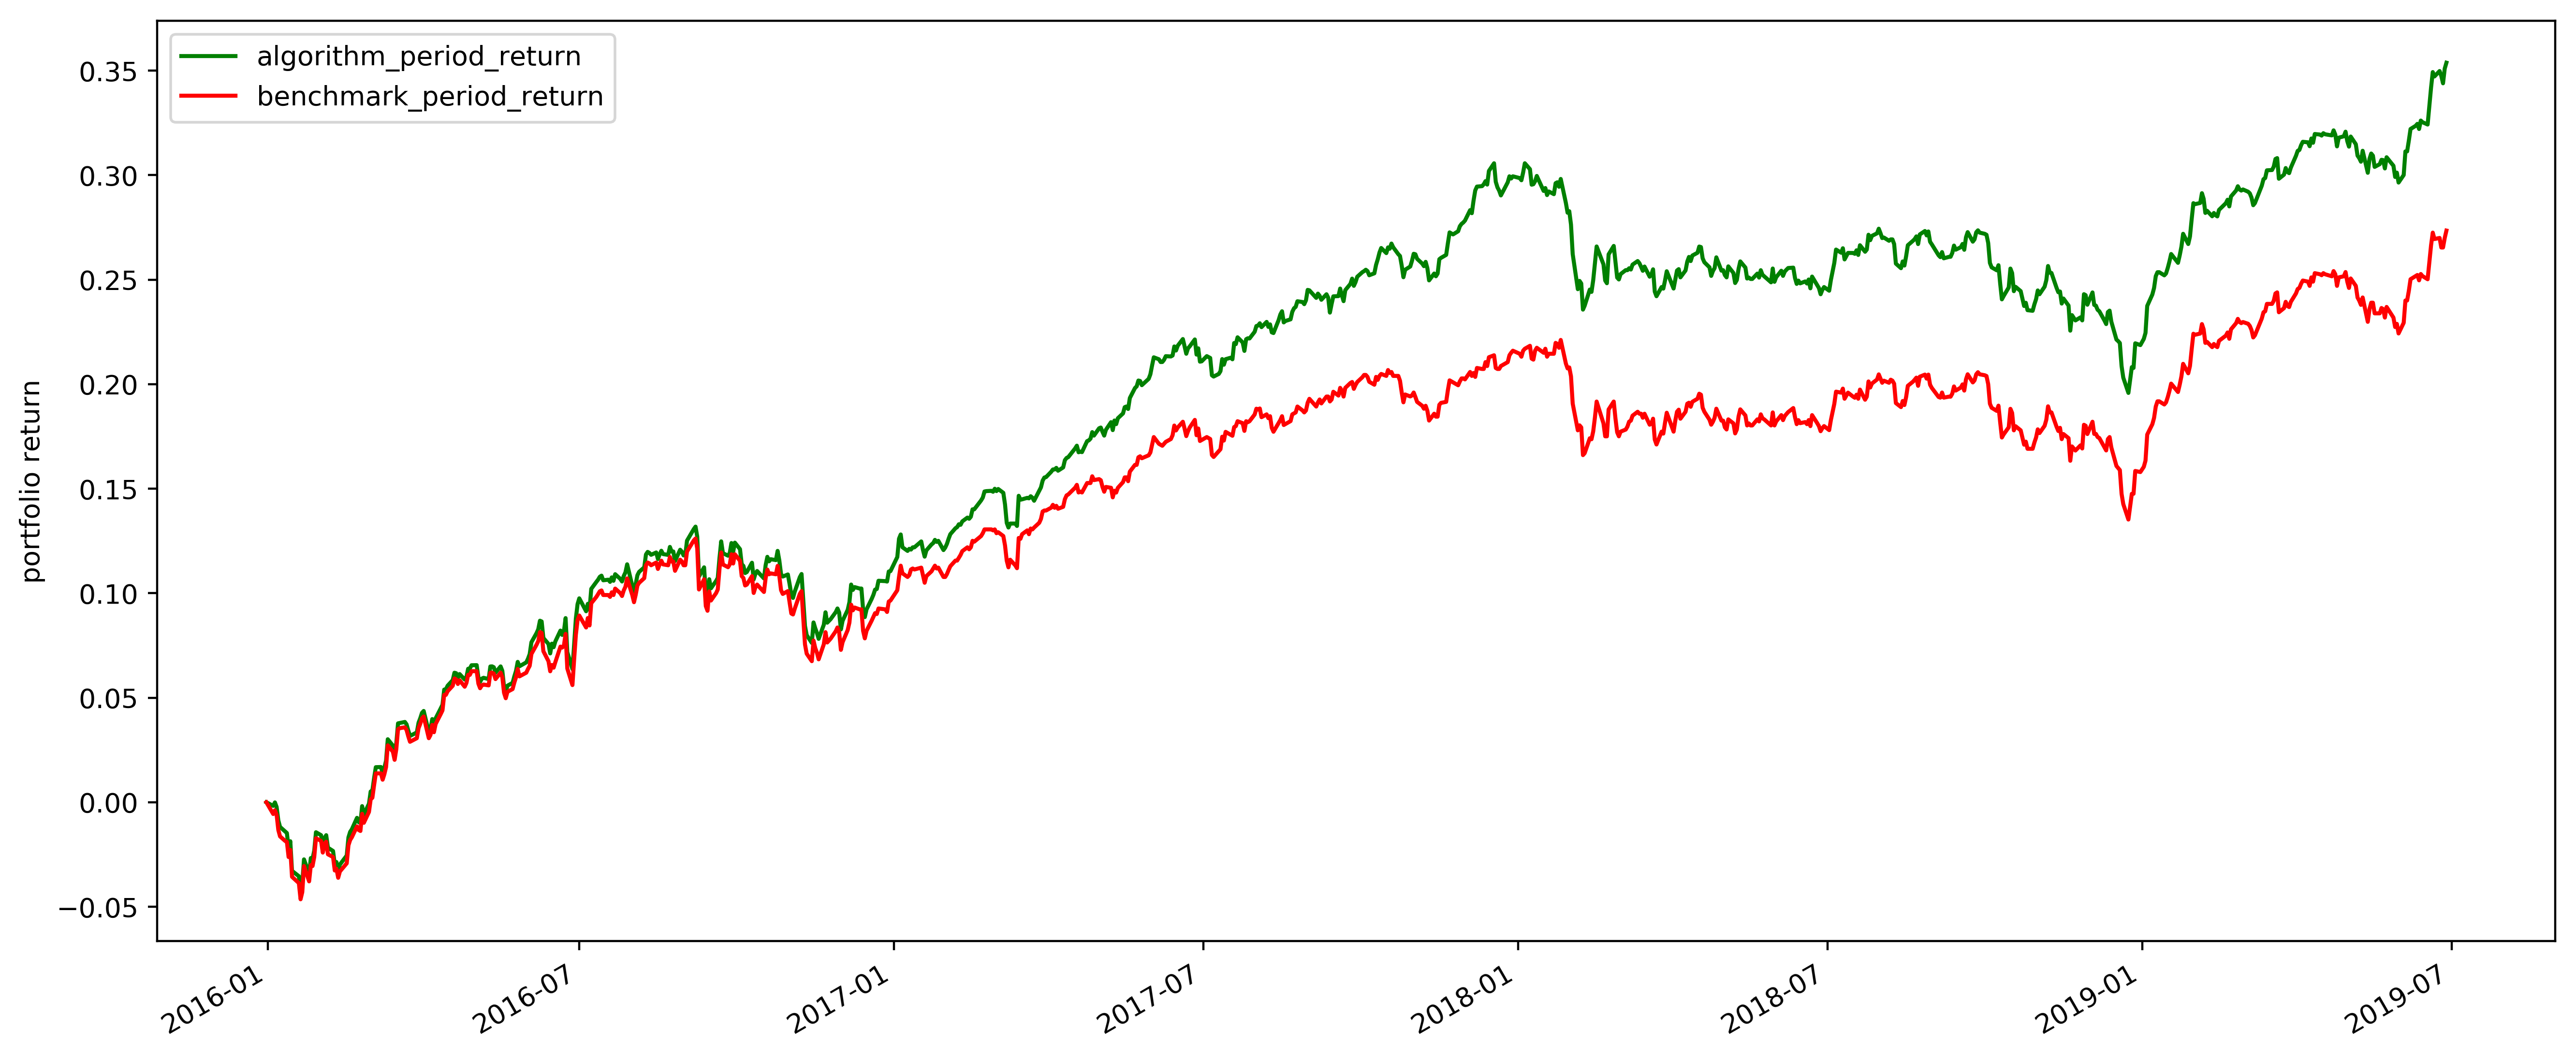

Final portfolio return: 35.38%
Final benchmark return: 27.35%


In [39]:
fig, ax = plt.subplots(figsize=[16, 7])

# portfolio value
perf.algorithm_period_return.plot(color='g')
perf.benchmark_period_return.plot(color='r')

ax.set_ylabel('portfolio return')

plt.legend()
plt.show()

print('Final portfolio return: {}%'.format(np.round(perf.algorithm_period_return[-1] * 100, 2)))
print('Final benchmark return: {}%'.format(np.round(perf.benchmark_period_return[-1] * 100, 2)))

In [40]:
bitcoin1 = perf.algorithm_period_return

In [41]:
blackrock = perf.benchmark_period_return

In [46]:
bitcoinPortfolio1 = 1000 * (1 + bitcoin1)
benchmark = 1000 * (1 + blackrock)

bitcoinPortfolio1 = bitcoinPortfolio1.rename('BTC 1% Target')
benchmark = benchmark.rename('No BTC') 

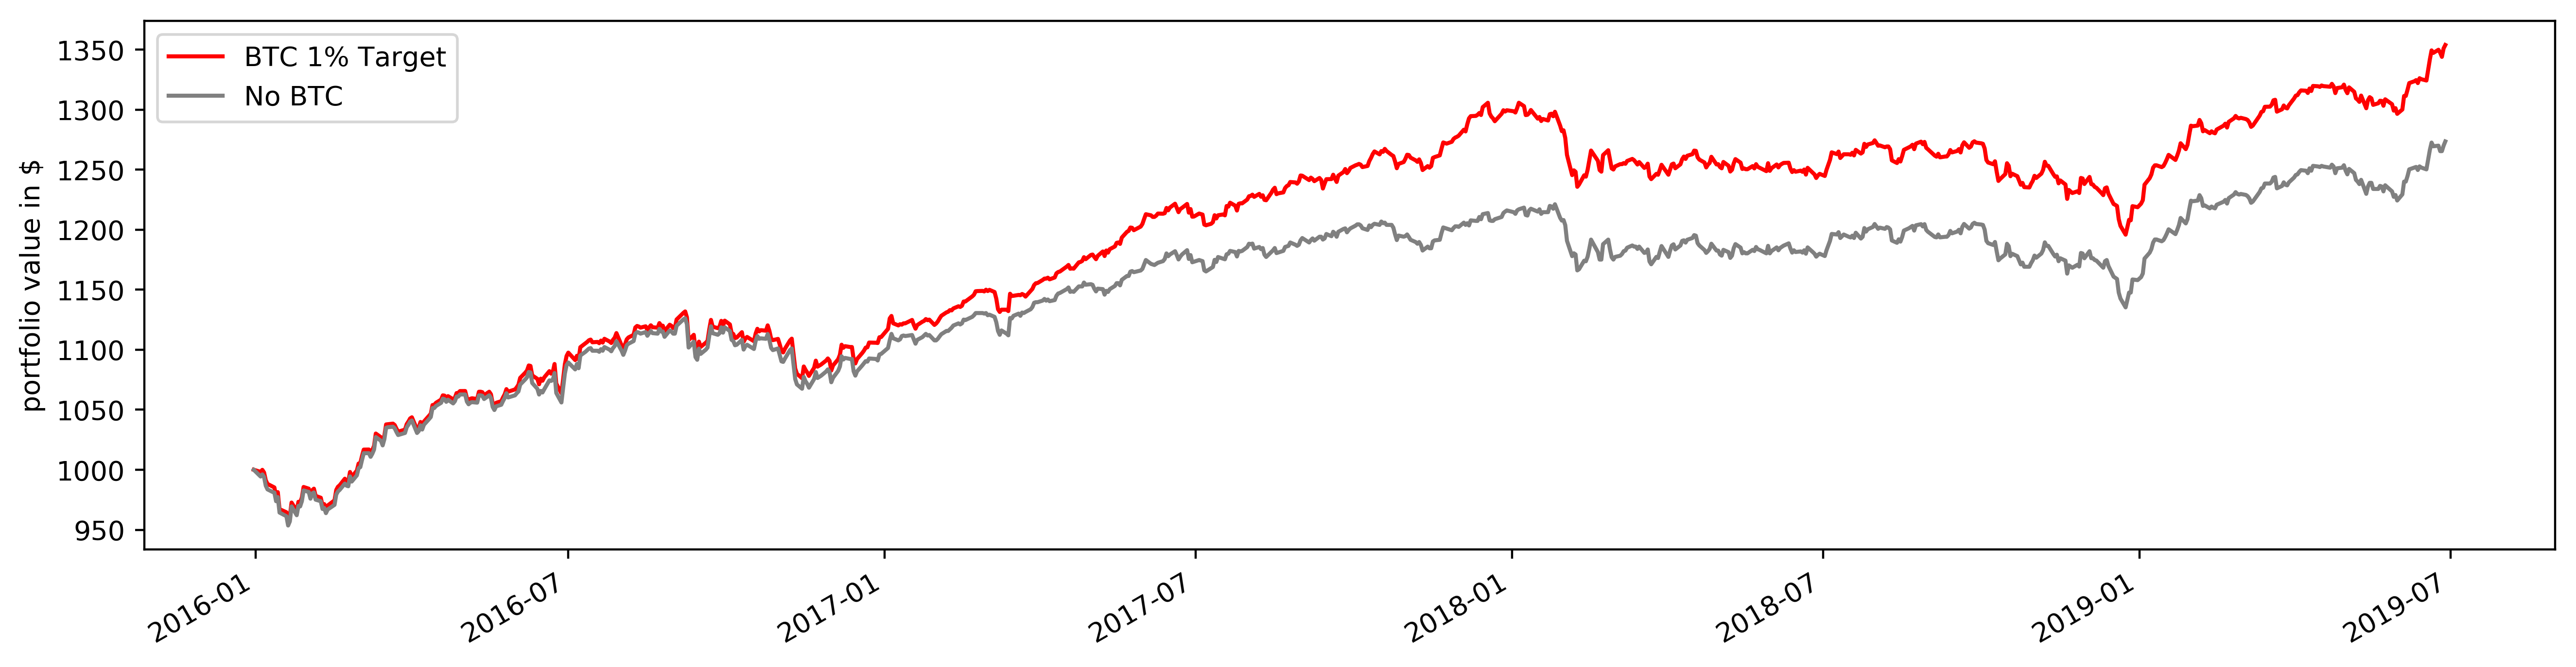

In [47]:
fig, ax = plt.subplots(figsize=[16, 4])

# portfolio value
bitcoinPortfolio1.plot(color='r')
benchmark.plot(color='gray')

ax.set_ylabel('portfolio value in $')

plt.legend()
plt.show()

In [48]:
#Поправляем индексацию

new_index = pd.Series(pd.to_datetime(positions.index).date).map(lambda x: x.strftime('%Y-%m-%d'))
weights_df = pd.DataFrame.from_records(positions, index=new_index)
weights_df.tail()

Equity(0 [IYLD])  Equity(1 [BTC])           cash
2019-06-24      1.313626e+07    224027.422852  137963.052271
2019-06-25      1.308909e+07    247308.397461  137963.052271
2019-06-26      1.308909e+07    212473.326172  137963.052271
2019-06-27      1.313626e+07    235739.308594  137963.052271
2019-06-28      1.317296e+07    227228.050781  137963.052271

In [49]:
# Поправляем названия столбцов

weights_df.columns = ['IYLD', 'BTC', 'Cash']

In [50]:
# Нормирование весов в файле

norm_weights_df = weights_df.copy()

norm_weights_df['BTC'] = weights_df['BTC']/(weights_df['BTC'] + weights_df['IYLD'] + weights_df['Cash'])    
norm_weights_df['IYLD'] = weights_df['IYLD']/(weights_df['IYLD'] + weights_df['BTC'] + weights_df['Cash'])
norm_weights_df['Cash'] = weights_df['Cash']/(weights_df['IYLD'] + weights_df['BTC'] + weights_df['Cash'])

In [51]:
# convert date objects from pandas format to python datetime
norm_weights_df.index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in norm_weights_df.index]

In [52]:
norm_weights_df.tail()

IYLD       BTC      Cash
2019-06-24  0.973182  0.016597  0.010221
2019-06-25  0.971407  0.018354  0.010239
2019-06-26  0.973925  0.015810  0.010265
2019-06-27  0.972339  0.017449  0.010212
2019-06-28  0.973025  0.016784  0.010191

ValueError: When stacked is True, each column must be either all positive or negative.Cash contains both positive and negative values

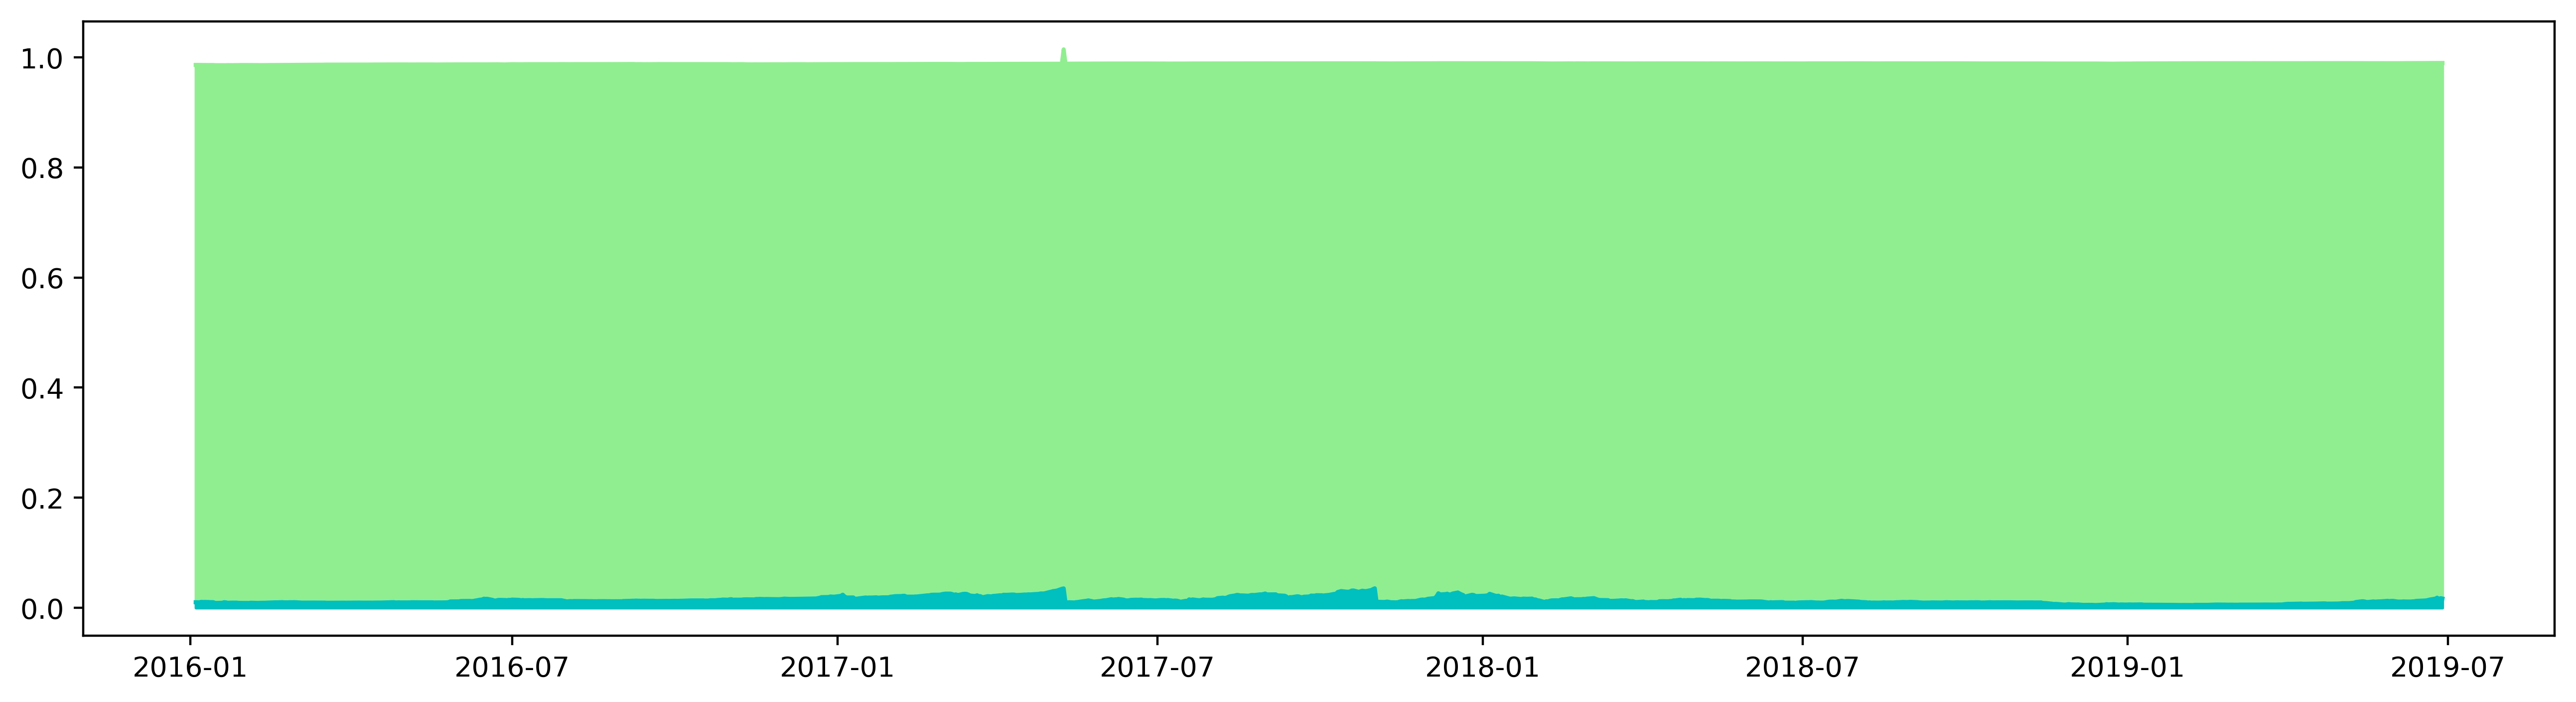

In [53]:
norm_weights_df = norm_weights_df[['BTC', 'IYLD', 'Cash']]
# plot the results
col = ['c', 'lightgreen', 'seagreen']
ax = norm_weights_df.plot(kind='area', stacked=True, color = col) # stacked=True показывает веса в одном столбце

# set monthly locator

##### Градуировка https://matplotlib.org/3.1.0/gallery/ticks_and_spines/tick-locators.html
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()

ax.tick_params(axis = 'both', direction = 'out')
ax.set(title = 'Paradigm strategy', ylabel='Allocation')
ax.legend(bbox_to_anchor=(1,1))
plt.show()

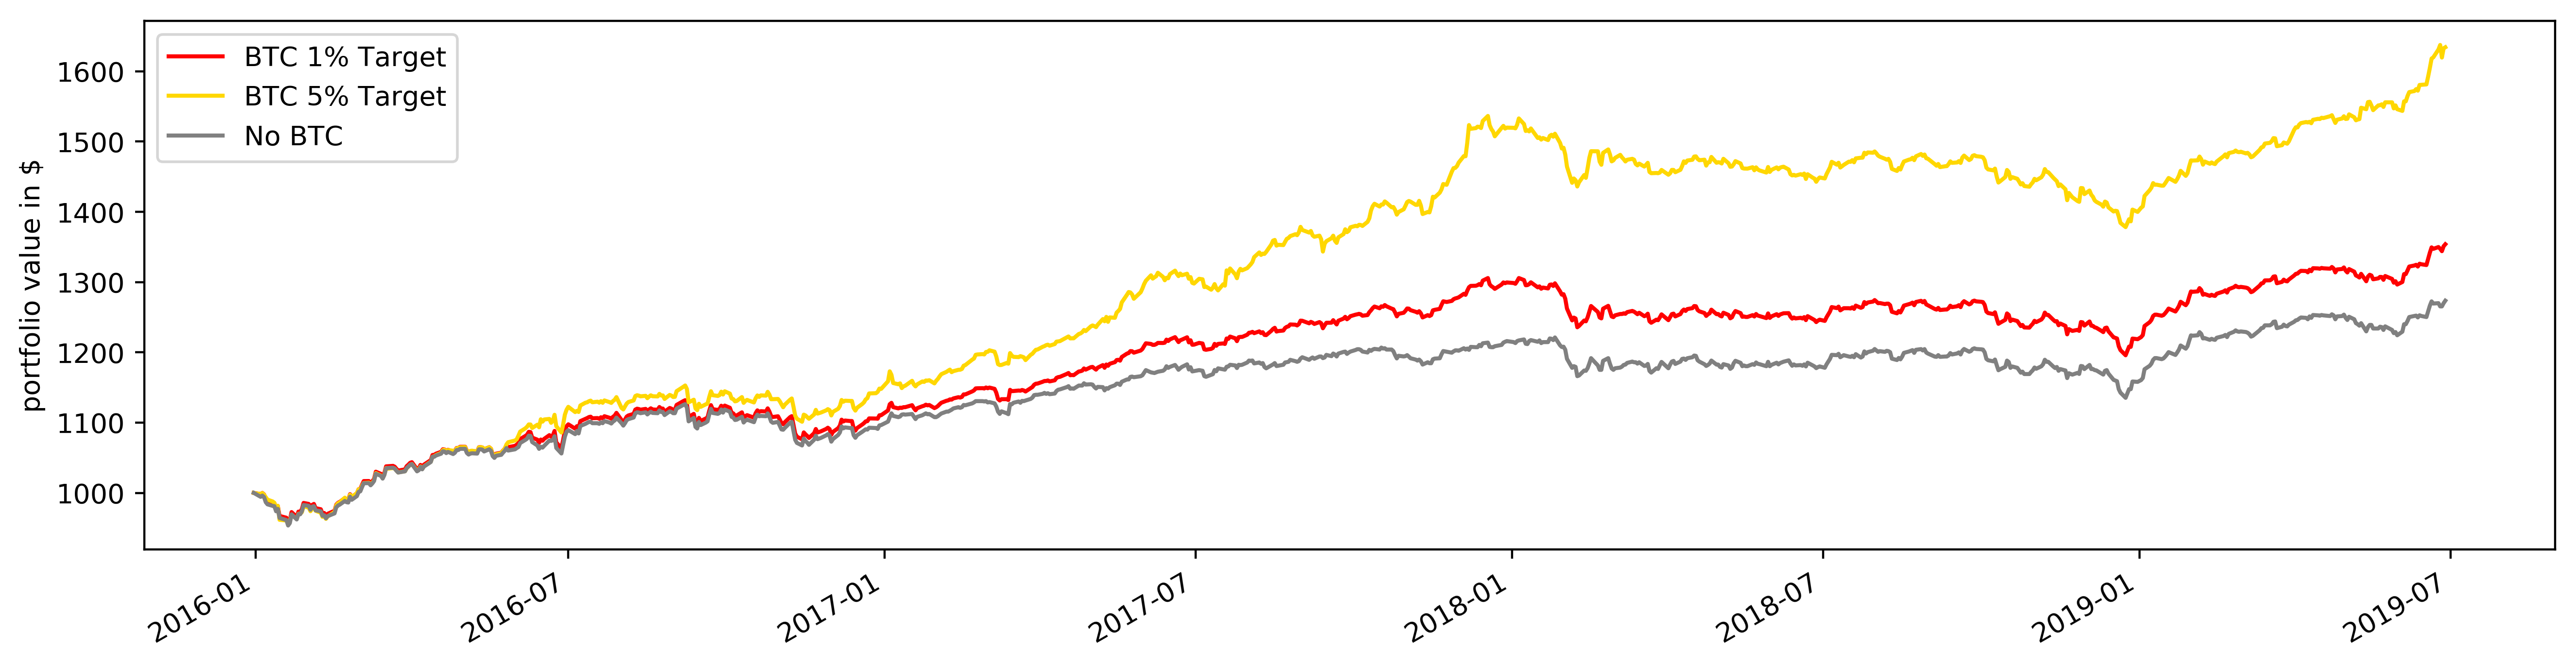

In [55]:
fig, ax = plt.subplots(figsize=[16, 4])

# portfolio value
bitcoinPortfolio1.plot(color='r')
bitcoinPortfolio5.plot(color='gold')
benchmark.plot(color='gray')

ax.set_ylabel('portfolio value in $')

plt.legend()
plt.show()

In [56]:
#fig.savefig('vanguard.png', transparent=False, dpi=800, bbox_inches="tight")

# Просадки

In [57]:
window = 365

In [58]:
# Calculate the max drawdown in the past window days for each day in the series.
# Use min_periods=1 if you want to let the first 365 days data have an expanding window
Roll_Max1 = pd.rolling_max(bitcoinPortfolio1, window, min_periods=1)
Roll_Max2 = pd.rolling_max(bitcoinPortfolio5, window, min_periods=1)
Roll_Max3 = pd.rolling_max(benchmark, window, min_periods=1)
Daily_Drawdown1 = bitcoinPortfolio1/Roll_Max1 - 1.0
Daily_Drawdown2 = bitcoinPortfolio5/Roll_Max2 - 1.0
Daily_Drawdown3 = benchmark/Roll_Max3 - 1.0

In [59]:
# Next we calculate the minimum (negative) daily drawdown in that window.
# Again, use min_periods=1 if you want to allow the expanding window
Max_Daily_Drawdown1 = pd.rolling_min(Daily_Drawdown1, window, min_periods=1)
Max_Daily_Drawdown2 = pd.rolling_min(Daily_Drawdown2, window, min_periods=1)
Max_Daily_Drawdown3 = pd.rolling_min(Daily_Drawdown3, window, min_periods=1)

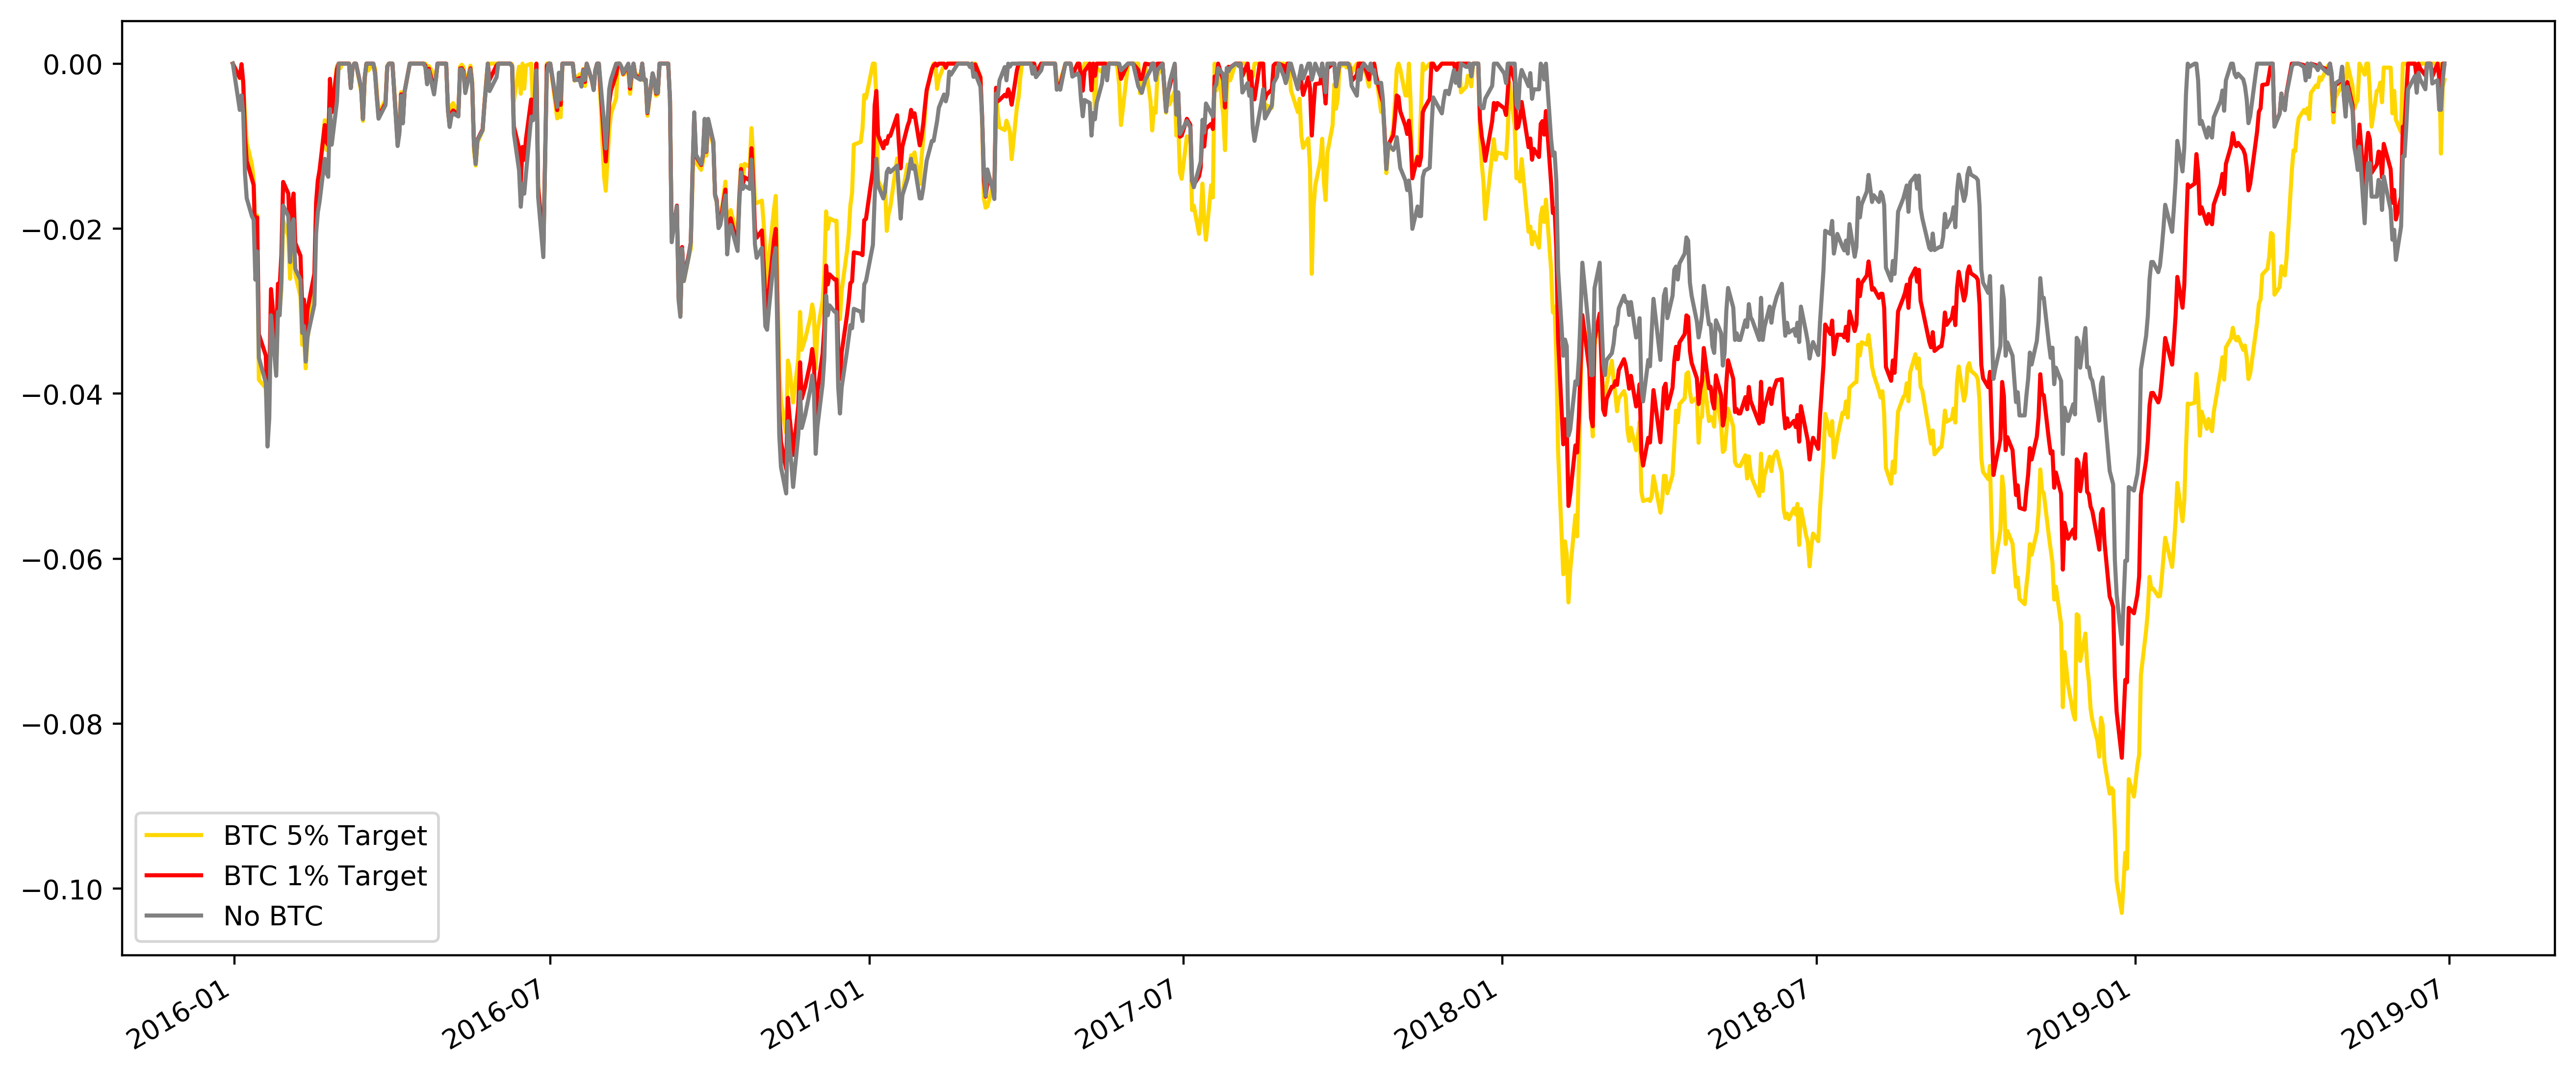

In [60]:
# Plot the results
fig, ax = plt.subplots(figsize=[16, 7])
Daily_Drawdown2.plot(color='gold', label='BTC 5% Target')
Daily_Drawdown1.plot(color='r', label='BTC 1% Target')
Daily_Drawdown3.plot(color='gray', label='No BTC')
plt.legend()
plt.show()

# Просто фонд BlackRock

In [62]:
# Список финансовых инструментов в портфеле
TIKERS = ['IYLD']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'close', 'adjclose']

In [63]:
data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    print(data[tiker].head())

             open      close   adjclose
date                                   
2015-12-31  23.35  23.270000  19.242931
2016-01-01  23.35  23.270000  19.242931
2016-01-02  23.35  23.270000  19.242931
2016-01-03  23.35  23.270000  19.242931
2016-01-04  23.27  23.139999  19.135437


In [64]:
for tiker in TIKERS:
    data[tiker]['close'] = data[tiker]['adjclose']
    data[tiker]['open'] = data[tiker]['adjclose']
    del data[tiker]['adjclose']
    print(data[tiker].tail())
COLUMNS = ['open', 'close']

                 open      close
date                            
2019-06-24  24.437832  24.437832
2019-06-25  24.350065  24.350065
2019-06-26  24.350065  24.350065
2019-06-27  24.437832  24.437832
2019-06-28  24.506094  24.506094


In [65]:
WEIGHTS = [1]
COMMISSION = 0.000125
DELTA = 0.025

In [66]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    
    context.tikers = TIKERS
    context.assets = [context.symbol(symbol) for symbol in context.tikers]
    
    context.weights = WEIGHTS
    context.n_assets = len(context.assets)
    
    context.window = 1
    
    context.rebalance_count = 0
    
    context.time = 0

In [67]:
def handle_data(context, data):
    
    if context.time == 0:
        
        # extract prices
        prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])
            
        context.time += 1
    
    else:
        for i, asset in enumerate(context.assets):
            if abs(context.portfolio.current_portfolio_weights.get(key = asset) - context.weights[i]) > DELTA:
                order_target_percent(asset, context.weights[i])
                
                context.rebalance_count += 1
                
        context.time += 1

In [68]:
perf = zipline.run_algorithm(start=datetime(2015, 12, 31, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2019, 6, 30, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              capital_base=10000000,
                              handle_data=handle_data,
                              data=panel)

In [69]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

In [70]:
qf.get_performance_summary(returns)

annual_volatility     0.056945
annualized_returns    0.072884
cumulative_returns    0.278476
max_drawdown         -0.070074
sharpe_ratio          1.264046
sortino_ratio         1.810235
dtype: float64